In [1]:
from command_def import CommandCode
from command_def import ResponseCode
from command_def import Color
from SerialInterface import SerialInterface

import image_processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from sklearn.datasets import load_files 
#Root Planner
from root_planner import PathPlanner, load_map_block, load_map_graph
import root_planner

port = "/dev/tty.hirojiren-SerialPortPro"
baud = 115200

In [2]:
def decodePacket(command, parameter):
    # 引数チェック
    if command != CommandCode.All and command != CommandCode.Specific: # 未定義のコマンドコード
        errmsg = "unsupported command"
        return None, errmsg

    return  None

def command_encodePacket(result):
    lrescode = ResponseCode.Command
    
    #data = struct.pack("B", len(result)) # 座標数
    data = struct.pack("B", 0) 
    for item in result:
        data += struct.pack("B", item) 
    return lrescode, struct.pack("B"*len(data), *data)

In [3]:
si = SerialInterface()
si.open(port, baud, None)

# 要求待ち受けのループ
while True:    
    command, parameter = si.read()
    print("(command, parameter) = ", (command, parameter))
    errmsg = decodePacket(command, parameter)
    
    if(command == 16):
        break

SerialInterface> connected
(command, parameter) =  (16, b'')


In [4]:
def cap_image():
    # Raspberry Pi3（Webサーバ）のURL
    # http://(Raspberry Pi3のIPアドレス)/?action=stream
    URL = "http://192.168.11.100/?action=stream"
    
    # VideoCaptureのインスタンスを作成する。
    cap = cv2.VideoCapture(URL)
    # カメラFPSを30FPSに設定
    cap.set(cv2.CAP_PROP_FPS, 30)
    # カメラ画像の横幅を1280に設定
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    # カメラ画像の縦幅を720に設定
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    # 表示するWindow名を設定
    WINDOW_NAME = "camera"
    cv2.namedWindow(WINDOW_NAME)
    ret, img = cap.read()
    return img   
    
img = cap_image()
cv2.imwrite('capture.jpg', img)

True

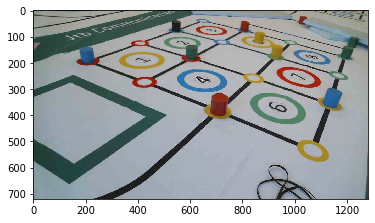

In [5]:
image = mpimg.imread('capture.jpg')
plt.imshow(image)

#IMAGE_DIR   = "image_fukuyama/"
#image_list = image_processing.load_image_set(IMAGE_DIR)
#image = image_list[9]
#image = image_list[8]
#plt.imshow(image)


# 画像処理部

In [6]:
img_psp = image_processing.persipective_image(image)
masked_image = image_processing.masked_image(img_psp)
block_img = []
num_img, block_img = image_processing.triming_image(masked_image)


In [7]:
for i in range(len(block_img)):
    filename = 'block_image/input/node/'
    if i < 10:
        filename = filename + str(0)+str(i)+'.jpg'
    else:
        filename = filename +str(i)+'.jpg'
    dst = cv2.cvtColor(block_img[i],cv2.COLOR_BGR2RGB)
    cv2.imwrite(filename, dst)

# ブロック推定部

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(28, 28))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [9]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()


model.add( Conv2D(16,  kernel_size = (2, 2),  input_shape=(28, 28, 3), activation = 'relu', strides = 1, padding = 'valid'))
model.add( MaxPooling2D(pool_size = (2, 2),  strides = 2))
model.add( Conv2D(32, kernel_size = (2, 2),  activation = 'relu', strides = 1, padding = 'valid'))
model.add( MaxPooling2D(pool_size = (2, 2),  strides = 2))
model.add( Conv2D(64, kernel_size = (2, 2),  activation = 'relu', strides = 1, padding = 'valid'))
model.add( MaxPooling2D(pool_size = (2, 2),  strides = 2))
model.add( GlobalAveragePooling2D())
model.add( Dense(units = 6, activation = 'softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
glob

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [12]:
data = load_files('block_image/input')
input_files = np.array(data['filenames'])
input_files = np.sort(input_files)
input_tensors = paths_to_tensor(input_files).astype('float32')/255

100%|██████████| 24/24 [00:00<00:00, 1891.10it/s]


In [13]:
#input_tensors
result = model.predict_proba(input_tensors, batch_size = 2)

In [14]:
block_image_list = []

for i in range(len(result)):
    im = mpimg.imread(input_files[i])
    block_image_list.append(im)

In [15]:
#print('0:none 1:red 2:green 3:blue 4:yellow 5:gray')
label = ['none','red','green', 'blue', 'yellow','gray']
#label[np.argmax(result[0])]


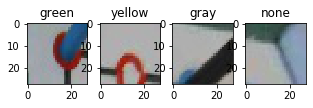

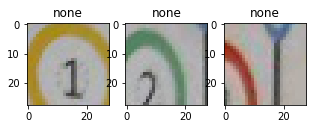

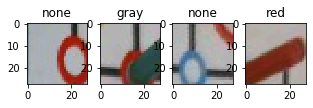

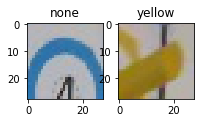

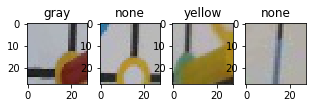

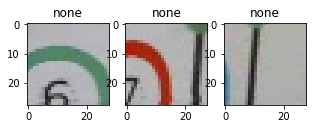

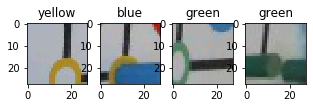

In [16]:


f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(5,5))
    
ax1.set_title(label[np.argmax(result[0])])
ax1.imshow(block_image_list[0])

ax2.set_title(label[np.argmax(result[1])])
ax2.imshow(block_image_list[1])

ax3.set_title(label[np.argmax(result[2])])
ax3.imshow(block_image_list[2])

ax4.set_title(label[np.argmax(result[3])])
ax4.imshow(block_image_list[3])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5,5))
ax1.set_title(label[np.argmax(result[4])])
ax1.imshow(block_image_list[4])

ax2.set_title(label[np.argmax(result[5])])
ax2.imshow(block_image_list[5])

ax3.set_title(label[np.argmax(result[6])])
ax3.imshow(block_image_list[6])


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title(label[np.argmax(result[7])])
ax1.imshow(block_image_list[7])

ax2.set_title(label[np.argmax(result[8])])
ax2.imshow(block_image_list[8])

ax3.set_title(label[np.argmax(result[9])])
ax3.imshow(block_image_list[9])

ax4.set_title(label[np.argmax(result[10])])
ax4.imshow(block_image_list[10])


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,3))
ax1.set_title(label[np.argmax(result[11])])
ax1.imshow(block_image_list[11])

ax2.set_title(label[np.argmax(result[12])])
ax2.imshow(block_image_list[12])


f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title(label[np.argmax(result[13])])
ax1.imshow(block_image_list[13])

ax2.set_title(label[np.argmax(result[14])])
ax2.imshow(block_image_list[14])

ax3.set_title(label[np.argmax(result[15])])
ax3.imshow(block_image_list[15])

ax4.set_title(label[np.argmax(result[16])])
ax4.imshow(block_image_list[16])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5,5))
ax1.set_title(label[np.argmax(result[17])])
ax1.imshow(block_image_list[17])

ax2.set_title(label[np.argmax(result[18])])
ax2.imshow(block_image_list[18])

ax3.set_title(label[np.argmax(result[19])])
ax3.imshow(block_image_list[19])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(5,5))
ax1.set_title(label[np.argmax(result[20])])
ax1.imshow(block_image_list[20])

ax2.set_title(label[np.argmax(result[21])])
ax2.imshow(block_image_list[21])

ax3.set_title(label[np.argmax(result[22])])
ax3.imshow(block_image_list[22])

ax4.set_title(label[np.argmax(result[23])])
ax4.imshow(block_image_list[23])


# 運搬経路探索部

In [17]:
block_node_list = [0, 2, 8, 10, 13, 15, 21, 23]
circle_node_list = [4, 5, 6, 11,12, 17, 18,19]

#print('0:none 1:red 2:green 3:blue 4:yellow 5:gray')
open_circle_dic ={4:4,  5:2, 6:1, 11:3, 12:4, 17:2, 18:1, 19:3}
closed_circle_dic={}
open_block_dic = {} 
closed_block_dic = {}
closed_gray_dic={}
block_list =[]
path_list = []

carry_block_mode = True

for i in range(24):
    block_list.append(np.argmax(result[i]))

#Open Block dic gen
for i in range(len(block_node_list)):
    key = block_node_list[i]
    open_block_dic[key] = block_list[key]

#Closed Block dic gen
for i in range(len(circle_node_list)):
    key = circle_node_list[i]
    block_color = block_list[key]
    if(block_color != 0):
        closed_block_dic[key] = block_color
        
map_block = load_map_block()
map_block
planner = PathPlanner(map_block)
start = 13

In [18]:
for num_search in range(15):
    print("num****************************", num_search)
    print("open_circle", open_circle_dic)
    print("closed_circle", closed_circle_dic)
    print("open_block_dic",  open_block_dic)
    print("closed_block_dic", closed_block_dic)

    if(carry_block_mode == True):
        block_color = open_block_dic[start]
        open_block_dic.pop(start)
        if(block_color == 5):
            nodes = [key for key, value in open_circle_dic.items() if value != 999]
        else:
            nodes = [key for key, value in open_circle_dic.items() if value == block_color]
    else:
        nodes = [key for key, value in open_block_dic.items() if value != 999]

    min_dic = 9999.9
    print(num_search)
    print(open_circle_dic)
    
    for node in nodes:
        dic = planner.distance(start, node)
        if dic < min_dic:
            min_dic = dic
            goal = node  
    print("nodes", nodes)
    print("start, goal, mode, clolor", start, goal, carry_block_mode, block_color)

    if(carry_block_mode == True and block_color != 5):
        open_circle_dic.pop(goal)
        closed_circle_dic[goal] = block_color

    map_block = load_map_block()
    map_block
    planner = PathPlanner(map_block,start,goal)


    for i in open_block_dic:
        if(i != goal):
            planner.closedSet.add(i)
        
    #for i in closed_block_dic:
     #   if(i != goal):
      #      planner.closedSet.add(i)
    for i in closed_circle_dic:
        if(i != goal):
            planner.closedSet.add(i)
            
    for i in closed_circle_dic:
        if(i != goal):
            planner.closedSet.add(i)

    for i in closed_gray_dic:
        if(i != goal):
            planner.closedSet.add(i)
            
    planner.run_search()
    path = planner.path

    if(carry_block_mode == True):
        path.append(path[-2])
        if block_color == 5: #Gray
            closed_gray_dic[goal] = block_color
            #print("closed_gray_dic",closed_gray_dic)
    
    path_list.append(path)

    closed_block_dic[goal] = block_color #使わないかも

    
    start = path[-1]
    
    print("path", path)
    #print("open_circle", open_circle_dic)
    #print("closed_circle", closed_circle_dic)
    #print("open_block_dic",  open_block_dic)
    #print("closed_block_dic", closed_block_dic)
    
    if (num_search%2 == 0):
        carry_block_mode = False
    else:
        carry_block_mode = True

num**************************** 0
open_circle {4: 4, 5: 2, 6: 1, 11: 3, 12: 4, 17: 2, 18: 1, 19: 3}
closed_circle {}
open_block_dic {0: 2, 2: 5, 8: 5, 10: 1, 13: 5, 15: 4, 21: 3, 23: 2}
closed_block_dic {12: 4}
0
{4: 4, 5: 2, 6: 1, 11: 3, 12: 4, 17: 2, 18: 1, 19: 3}
nodes [4, 5, 6, 11, 12, 17, 18, 19]
start, goal, mode, clolor 13 11 True 5
path [13, 11, 13]
num**************************** 1
open_circle {4: 4, 5: 2, 6: 1, 11: 3, 12: 4, 17: 2, 18: 1, 19: 3}
closed_circle {}
open_block_dic {0: 2, 2: 5, 8: 5, 10: 1, 15: 4, 21: 3, 23: 2}
closed_block_dic {12: 4, 11: 5}
1
{4: 4, 5: 2, 6: 1, 11: 3, 12: 4, 17: 2, 18: 1, 19: 3}
nodes [0, 2, 8, 10, 15, 21, 23]
start, goal, mode, clolor 13 8 False 5
path [13, 7, 8]
num**************************** 2
open_circle {4: 4, 5: 2, 6: 1, 11: 3, 12: 4, 17: 2, 18: 1, 19: 3}
closed_circle {}
open_block_dic {0: 2, 2: 5, 8: 5, 10: 1, 15: 4, 21: 3, 23: 2}
closed_block_dic {12: 4, 11: 5, 8: 5}
2
{4: 4, 5: 2, 6: 1, 11: 3, 12: 4, 17: 2, 18: 1, 19: 3}
nodes [4, 5, 

In [19]:
path_list

[[13, 11, 13],
 [13, 7, 8],
 [8, 4, 8],
 [8, 1, 0],
 [0, 1, 5, 1],
 [1, 2],
 [2, 6, 2],
 [2, 3, 10],
 [10, 6, 10],
 [10, 12, 15],
 [15, 12, 15],
 [15, 18, 21],
 [21, 14, 11, 14],
 [14, 15, 19, 23],
 [23, 22, 21, 17, 21]]

In [20]:
response, parameter =command_encodePacket(path_list[0])
print(response, parameter)
command = 0

while True: 
    command, param = si.read()
    if(command == 16):
        print("done")
        si.write(response, parameter)
        break

NameError: name 'struct' is not defined